In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random

# Classifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
#from sklearn.lda import LDA
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import *
#from sklearn.neighbors import KNeighborsClassifier
from pandas import Series

from utilities.losses import compute_loss
from utilities.optimizers import gradient_descent, pso, mini_batch_gradient_descent
from sklearn.model_selection import train_test_split

# General settings
from utilities.visualization import visualize_train, visualize_test

In [2]:
seed = 309
# Freeze the random seed
random.seed(seed)
np.random.seed(seed)
train_test_split_test_size = 0.1

# Training settings
alpha = 0.1  # step size
max_iters = 50  # max iterations


In [3]:
# Load Data from CSV
# :return: df    a panda data frame
def load_data():
    df = pd.read_csv("../data/Part 2 - classification/adult.csv")
    
    return df
#load_data()

In [4]:
#dealing with outilers
def dealingOutilers(data):
    
    data2=data.copy()
    IRQ = data.quantile(.75)-data.quantile(.25)
    data2[data<data.quantile(.25)-IRQ*1.5]=data.quantile(.25)
    data2[data>data.quantile(.75)+IRQ*1.5]=data.quantile(.75)
    
    return data2
    
    

In [5]:
def convertCategoricalToNumeric(data,binNum):
    
    data2=data.copy()
    datamax = int(data.max())
    datamin = int(data.min())
    #print(datamax,datamin)
    binRange=int((datamax-datamin)/binNum)
                 
    labels = ["{0} - {1}".format(i, i + binRange-1) for i in range(datamin, datamax, binRange)]
    data2 = pd.cut(data, range(datamin, datamax+binRange, binRange), right=False, labels=labels)
    #print(data2.unique())
    return data2
    
    

In [6]:
def data_preprocess(data):
    """
    Data preprocess:
        1. Split the entire dataset into train and test
        2. Split outputs and inputs
        3. Standardize train and test
        4. Add intercept dummy for computation convenience
    :param data: the given dataset (format: panda DataFrame)
    :return: train_data       train data contains only inputs
             train_labels     train data contains only labels
             test_data        test data contains only inputs
             test_labels      test data contains only labels
             train_data_full       train data (full) contains both inputs and labels
             test_data_full       test data (full) contains both inputs and labels
    """
    #Add attribute name
    data.columns = ["Age", "Workclass", "Final_Weight", "Education", "Highest_Grade", "Marital_Status", "Occupation", "Relationship", "Race", "Sex", "Capital_Gain", "Capital_Loss", "Hours_per_Week", "Native_Country", "Income_Class"]
    #check the attributes
#     for column in data.columns:
#         print(column, ":", data[column].unique(),"\n")
    
    #show the class graph, check unbanlance 
#     data.hist(bins=10, figsize=(14,10))
#     plt.show()
    print(data["Income_Class"].value_counts())
    data["Income_Class"].value_counts().plot(kind='bar');
    plt.axhline(0, color='k')
    #plt.show()
    #print(data.groupby("Income_Class").mean())
    
    #dealing with outilers
    
    print(data.describe())
    data["Age"]=dealingOutilers(data["Age"])
    data["Final_Weight"]=dealingOutilers(data["Final_Weight"])
    data["Highest_Grade"]=dealingOutilers(data["Highest_Grade"])
    data["Hours_per_Week"]=dealingOutilers(data["Hours_per_Week"])
    print(data.describe())
    
    data.hist(bins=10, figsize=(14,10))
    plt.show()
    
    #convert numeric to categorical
    
    data["Age"]=convertCategoricalToNumeric(data["Age"],8)
    data["Final_Weight"]=convertCategoricalToNumeric(data["Final_Weight"],10)
    data["Highest_Grade"]=convertCategoricalToNumeric(data["Highest_Grade"],5)
    data["Hours_per_Week"]=convertCategoricalToNumeric(data["Hours_per_Week"],5)
    #print(data)

    # print(data)
    from sklearn import preprocessing
    from sklearn.preprocessing import StandardScaler
    
    le = preprocessing.LabelEncoder()
    
    #replace NAN
    data=data.replace(' ?',np.nan)
    data=data.fillna(method='ffill')
    print(data.isnull().values.any())
    
    # Converting string labels into numbers.
    data["Age"]=le.fit_transform(data["Age"])
    data["Workclass"]=le.fit_transform(data["Workclass"])
    data["Final_Weight"]=le.fit_transform(data["Final_Weight"])
    data["Education"]=le.fit_transform(data["Education"])
    data["Highest_Grade"]=le.fit_transform(data["Highest_Grade"])
    data["Marital_Status"]=le.fit_transform(data["Marital_Status"])
    data["Occupation"]=le.fit_transform(data["Occupation"])
    data["Relationship"]=le.fit_transform(data["Relationship"])
    data["Race"]=le.fit_transform(data["Race"])
    data["Sex"]=le.fit_transform(data["Sex"])
    data["Capital_Gain"]=le.fit_transform(data["Capital_Gain"])
    data["Capital_Loss"]=le.fit_transform(data["Capital_Loss"])
    data["Hours_per_Week"]=le.fit_transform(data["Hours_per_Week"])
    data["Native_Country"]=le.fit_transform(data["Native_Country"])
    data["Income_Class"]=le.fit_transform(data["Income_Class"])
    #print(data)
    
    # Split the data into train and test
    train_data, test_data = train_test_split(data, test_size = train_test_split_test_size)
    
    # Pre-process data (both train and test)
    train_data_full = train_data.copy()
    train_data = train_data.drop(["Income_Class"], axis = 1)
    train_labels = train_data_full["Income_Class"]

    test_data_full = test_data.copy()
    test_data = test_data.drop(["Income_Class"], axis = 1)
    test_labels = test_data_full["Income_Class"]

    #Standardize the inputs
    
    scaler = StandardScaler()
    scaler.fit(train_data)
    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)
    
    #print(train_data)
  
    return train_data, train_labels, test_data, test_labels, train_data_full, test_data_full


 <=50K    24719
 >50K      7841
Name: Income_Class, dtype: int64
                Age  Final_Weight  Highest_Grade  Capital_Gain  Capital_Loss  \
count  32560.000000  3.256000e+04   32560.000000  32560.000000  32560.000000   
mean      38.581634  1.897818e+05      10.080590   1077.615172     87.306511   
std       13.640642  1.055498e+05       2.572709   7385.402999    402.966116   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178315e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783630e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370545e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       Hours_per_Week  
count    32560.000000  
mean        40.437469  
std         12.347618  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000 

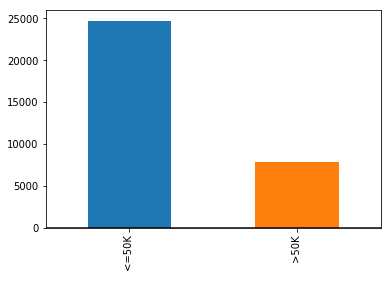

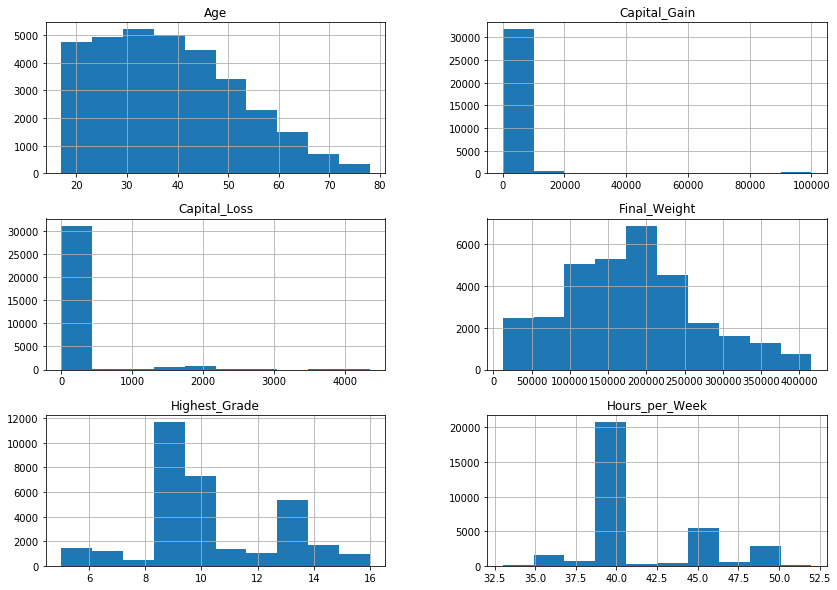

78 17
415847 12285
16 5
52 33
False
Learn: execution time=2.522 seconds
confusion_matrix:
 [[2257  224]
 [ 311  464]]
accuracy_score: 0.84
auc: 0.75
             precision    recall  f1-score   support

          0       0.88      0.91      0.89      2481
          1       0.67      0.60      0.63       775

avg / total       0.83      0.84      0.83      3256



In [7]:
if __name__ == '__main__':
    # Settings
    metric_type = "R2"  # MSE, RMSE, MAE, R2
    optimizer_type = "PSO"  # PSO, BGD, MiniBGD

    # Step 1: Load Data
    data = load_data()

    # Step 2: Preprocess the data
    train_data, train_labels, test_data, test_labels, train_data_full, test_data_full = data_preprocess(data)
    
    # Step 3: Learning Start

    start_time = datetime.datetime.now()  # Track learning starting time

#   Classifier
    baseline = KNeighborsClassifier(n_neighbors=11)
#    baseline = GaussianNB()
#    baseline = svm.SVC(gamma='auto')
#    baseline = DecisionTreeClassifier(random_state=0)
#    baseline = RandomForestClassifier(n_estimators=100, max_depth=9, random_state=0)
#    baseline = AdaBoostClassifier(DecisionTreeClassifier(max_depth=9),algorithm="SAMME",n_estimators=200)
#    baseline = GradientBoostingClassifier()
#    baseline = LinearDiscriminantAnalysis()
#    baseline = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
#    baseline = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

    
    baseline.fit(train_data,train_labels)
    #Prediction
    y_pred = baseline.predict(test_data)
    #print(y_pred)
    
    end_time = datetime.datetime.now()  # Track learning ending time
    exection_time = (end_time - start_time).total_seconds()  # Track execution time

   # Step 4: Results presentation
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score,recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import classification_report
    
    print("Learn: execution time={t:.3f} seconds".format(t = exection_time))

   # Build baseline model

    print("confusion_matrix:\n {}".format(confusion_matrix(test_labels,y_pred)))
    print("accuracy_score: {:.2f}".format(accuracy_score(test_labels,y_pred)))
    print("auc: {:.2f}".format(roc_auc_score(test_labels,y_pred)))
    print(classification_report(test_labels,y_pred))
